In [1]:
!pip install pprint

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


In [2]:
import wandb
import pprint
import time
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import scipy.sparse as sp
import numpy as np
import torch
import os
import enum
import torch.nn as nn
from torch.optim import Adam
from torch.optim import SGD
from torch.optim import Adadelta
from torch.utils.tensorboard import SummaryWriter
import git
import re
import argparse
from sklearn.manifold import TSNE
from scipy.stats import entropy

2024-05-13 23:34:53.064052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 23:34:53.114472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 23:34:53.985442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Supported datasets - only Cora in this notebook
class DatasetType(enum.Enum):
    CORA = 0

    
# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')  # this is checked-in no need to make a directory

#
# Cora specific constants
#

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')

def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

In [5]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [6]:
def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


In [7]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):

    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=int)
    out_degrees = np.zeros(num_of_nodes, dtype=int)

    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

Visualizing Cora's degree distributions

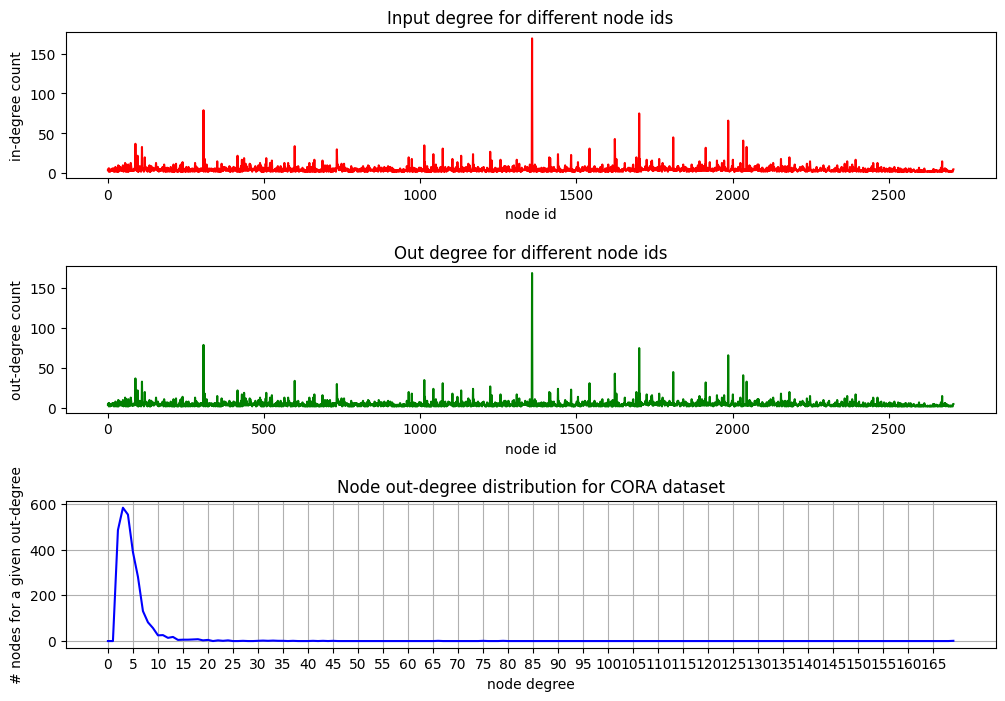

In [8]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

In [9]:
dataset_name = config['dataset_name']
visualization_tool=GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
# go berserk here try (3000, 3000) it looks amazing in Jupyter!!! (you'll have to adjust the vertex_size though!)
visual_style["bbox"] = (700, 700)
visual_style["margin"] = 5

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
else:
    print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)


Plotting results ... (it may take couple of seconds).


In [10]:
class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

In [11]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    
    src_nodes_dim = 0  
    trg_nodes_dim = 1  
    nodes_dim = 0      
    head_dim = 1      

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        in_nodes_features = self.dropout(in_nodes_features)

        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        # Step 2: Edge attention calculation
        
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        # Step 3: Neighborhood aggregation

        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        # Step 4: Residual/skip connections, concat and bias

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)


    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

In [12]:
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default

BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [13]:
def get_training_state(training_config, model):
    training_state = {
        "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict': 
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')



def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

In [14]:
def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "num_of_layers": 2,  
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [CORA_NUM_INPUT_FEATURES, 8, CORA_NUM_CLASSES],
        "add_skip_connection": False,  # hurts perf on Cora
        "bias": True,  # result is not so sensitive to bias
        "dropout": 0.4,  # result is sensitive to dropout
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)
    print("ggwp")
    # Add additional config information
    training_config.update(gat_config)
    print(training_config)

    return training_config

In [15]:
def train_gat(config, optimizerval, lrval, epochss):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    if optimizerval == 'Adam':
        optimizer = Adam(gat.parameters(), lr=lrval)
    elif optimizerval == 'SGD':
        optimizer = SGD(gat.parameters(), lr=lrval, momentum=0.9)
    elif optimizerval == 'Adadelta':
        optimizer = Adadelta(gat.parameters(), lr=lrval, weight_decay=config['weight_decay'])

    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping

    # Step 4: Start the training procedure
    for epoch in range(epochss):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1

    # Save the latest GAT in the binaries directory
    torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))

In [16]:
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0 

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    graph_data = (node_features, edge_index) 

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)  
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  
            loss.backward()  
            optimizer.step() 

        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            wandb.log({"epoch": epoch})
            wandb.log({"training_loss": loss.item()})
            wandb.log({"training_acc": accuracy})
            
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            wandb.log({"val_loss": loss.item()})
            wandb.log({"val_acc": accuracy})
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC) 
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0  
            else:
                PATIENCE_CNT += 1  

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy 

    return main_loop  

In [17]:
!wandb login 3b0311b8e53fccf34f947a23cec3783cb54aa5c0

sweep_config = {
    'method': 'random',
}

parameters_dict = {
    'lrval': {
        'values': [1, 0.1, 0.01, 0.001]
      },
    'optimizerval': {
        'values': ['Adam', 'Adadelta']
        },
    'epochss': {
        'values': [800, 1200, 1600, 2000]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="dl-gat-project-run3")

Traceback (most recent call last):
  File "/home/vg2507/.local/bin/wandb", line 5, in <module>
    from wandb.cli.cli import cli
  File "/home/vg2507/.local/lib/python3.11/site-packages/wandb/__init__.py", line 22, in <module>
    from wandb.errors import Error
ModuleNotFoundError: No module named 'wandb.errors'


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'method': 'random',
 'parameters': {'epochss': {'values': [800, 1200, 1600, 2000]},
                'lrval': {'values': [1, 0.1, 0.01, 0.001]},
                'optimizerval': {'values': ['Adam', 'Adadelta']}}}
Create sweep with ID: k56rydo1
Sweep URL: https://wandb.ai/team9449/dl-gat-project-run3/sweeps/k56rydo1


In [18]:
def sweepFunction(config=None):
    with wandb.init(config=config):
        config = wandb.config
        train_gat(get_training_args(), config.optimizerval, config.lrval, config.epochss)

wandb.agent(sweep_id, sweepFunction, count=16)

wandb: Agent Starting Run: 6yqdo7ex with config:
wandb: 	epochss: 1200
wandb: 	lrval: 1
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vishgoki (team9449). Use `wandb login --relogin` to force relogin


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.38 [s] | epoch=1 | val acc=0.298
GAT training: time elapsed= 1.26 [s] | epoch=101 | val acc=0.156
GAT training: time elapsed= 2.12 [s] | epoch=201 | val acc=0.162
GAT training: time elapsed= 2.97 [s] | epoch=301 | val acc=0.114
GAT training: time elapsed= 3.82 [s] | epoch=401 | val acc=0.316
GAT training: time elapsed= 4.68 [s] | epoch=501 | val acc=0.156
GAT training: time elapsed= 5.53 [s] | epoch=601 | val acc=0.072
GAT training: time elapsed= 6.38 [s] | epoch=701 | val acc=0.122
GAT training: time elapsed= 7.23 [s] | epoch=801 | val acc=0.122
GAT training: time elapsed= 8.09 [s] | epoch=901 | val acc=0.162
GAT training: time elapsed= 9.04 [s] | epoch=1001 | val acc=0.316
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.103


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fgydzxzg with config:
wandb: 	epochss: 1600
wandb: 	lrval: 1
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.156


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.88 [s] | epoch=101 | val acc=0.314
GAT training: time elapsed= 1.72 [s] | epoch=201 | val acc=0.058
GAT training: time elapsed= 2.46 [s] | epoch=301 | val acc=0.122
GAT training: time elapsed= 3.43 [s] | epoch=401 | val acc=0.314
GAT training: time elapsed= 4.29 [s] | epoch=501 | val acc=0.072
GAT training: time elapsed= 5.13 [s] | epoch=601 | val acc=0.122
GAT training: time elapsed= 5.98 [s] | epoch=701 | val acc=0.114
GAT training: time elapsed= 6.83 [s] | epoch=801 | val acc=0.058
GAT training: time elapsed= 7.61 [s] | epoch=901 | val acc=0.072
GAT training: time elapsed= 8.64 [s] | epoch=1001 | val acc=0.16
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.13


wandb: Agent Starting Run: pchdb2lc with config:
wandb: 	epochss: 2000
wandb: 	lrval: 1
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.156


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.89 [s] | epoch=101 | val acc=0.114
GAT training: time elapsed= 1.72 [s] | epoch=201 | val acc=0.068
GAT training: time elapsed= 2.52 [s] | epoch=301 | val acc=0.158
GAT training: time elapsed= 3.42 [s] | epoch=401 | val acc=0.316
GAT training: time elapsed= 4.27 [s] | epoch=501 | val acc=0.058
GAT training: time elapsed= 5.11 [s] | epoch=601 | val acc=0.122
GAT training: time elapsed= 5.96 [s] | epoch=701 | val acc=0.156
GAT training: time elapsed= 6.82 [s] | epoch=801 | val acc=0.072
GAT training: time elapsed= 7.66 [s] | epoch=901 | val acc=0.058
GAT training: time elapsed= 8.62 [s] | epoch=1001 | val acc=0.058
GAT training: time elapsed= 9.37 [s] | epoch=1101 | val acc=0.114
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.13


wandb: Agent Starting Run: 4czhb7gq with config:
wandb: 	epochss: 800
wandb: 	lrval: 0.1
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.23


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.87 [s] | epoch=101 | val acc=0.308
GAT training: time elapsed= 1.71 [s] | epoch=201 | val acc=0.498
GAT training: time elapsed= 2.49 [s] | epoch=301 | val acc=0.554
GAT training: time elapsed= 3.40 [s] | epoch=401 | val acc=0.642
GAT training: time elapsed= 4.25 [s] | epoch=501 | val acc=0.672
GAT training: time elapsed= 5.09 [s] | epoch=601 | val acc=0.702
GAT training: time elapsed= 5.93 [s] | epoch=701 | val acc=0.7
Test accuracy = 0.707


wandb: Agent Starting Run: j49ziv9y with config:
wandb: 	epochss: 800
wandb: 	lrval: 1
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.098


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.88 [s] | epoch=101 | val acc=0.698
GAT training: time elapsed= 1.71 [s] | epoch=201 | val acc=0.564
GAT training: time elapsed= 2.51 [s] | epoch=301 | val acc=0.734
GAT training: time elapsed= 3.41 [s] | epoch=401 | val acc=0.766
GAT training: time elapsed= 4.27 [s] | epoch=501 | val acc=0.788
GAT training: time elapsed= 5.11 [s] | epoch=601 | val acc=0.796
GAT training: time elapsed= 5.96 [s] | epoch=701 | val acc=0.808
Test accuracy = 0.828


wandb: Agent Starting Run: pv7a9hhc with config:
wandb: 	epochss: 800
wandb: 	lrval: 0.1
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.168


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.88 [s] | epoch=101 | val acc=0.776
GAT training: time elapsed= 1.72 [s] | epoch=201 | val acc=0.112
GAT training: time elapsed= 2.58 [s] | epoch=301 | val acc=0.156
GAT training: time elapsed= 3.41 [s] | epoch=401 | val acc=0.316
GAT training: time elapsed= 4.27 [s] | epoch=501 | val acc=0.316
GAT training: time elapsed= 5.12 [s] | epoch=601 | val acc=0.316
GAT training: time elapsed= 5.97 [s] | epoch=701 | val acc=0.316
Test accuracy = 0.144


wandb: Agent Starting Run: fukh0x92 with config:
wandb: 	epochss: 800
wandb: 	lrval: 0.001
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.184


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.87 [s] | epoch=101 | val acc=0.186
GAT training: time elapsed= 1.68 [s] | epoch=201 | val acc=0.19
GAT training: time elapsed= 2.56 [s] | epoch=301 | val acc=0.188
GAT training: time elapsed= 3.39 [s] | epoch=401 | val acc=0.188
GAT training: time elapsed= 4.24 [s] | epoch=501 | val acc=0.19
GAT training: time elapsed= 5.08 [s] | epoch=601 | val acc=0.194
GAT training: time elapsed= 5.92 [s] | epoch=701 | val acc=0.196
Test accuracy = 0.19


wandb: Agent Starting Run: ch0y8ibi with config:
wandb: 	epochss: 2000
wandb: 	lrval: 1
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.08


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.88 [s] | epoch=101 | val acc=0.072
GAT training: time elapsed= 1.70 [s] | epoch=201 | val acc=0.072
GAT training: time elapsed= 2.54 [s] | epoch=301 | val acc=0.114
GAT training: time elapsed= 3.41 [s] | epoch=401 | val acc=0.156
GAT training: time elapsed= 4.27 [s] | epoch=501 | val acc=0.316
GAT training: time elapsed= 5.11 [s] | epoch=601 | val acc=0.316
GAT training: time elapsed= 5.96 [s] | epoch=701 | val acc=0.122
GAT training: time elapsed= 6.82 [s] | epoch=801 | val acc=0.162
GAT training: time elapsed= 7.66 [s] | epoch=901 | val acc=0.156
GAT training: time elapsed= 8.62 [s] | epoch=1001 | val acc=0.114
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.104


wandb: Agent Starting Run: glbwl8jr with config:
wandb: 	epochss: 1600
wandb: 	lrval: 0.001
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.182


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.89 [s] | epoch=101 | val acc=0.802
GAT training: time elapsed= 1.73 [s] | epoch=201 | val acc=0.804
GAT training: time elapsed= 2.59 [s] | epoch=301 | val acc=0.792
GAT training: time elapsed= 3.47 [s] | epoch=401 | val acc=0.784
GAT training: time elapsed= 4.32 [s] | epoch=501 | val acc=0.782
GAT training: time elapsed= 5.28 [s] | epoch=601 | val acc=0.798
GAT training: time elapsed= 6.20 [s] | epoch=701 | val acc=0.796
GAT training: time elapsed= 7.05 [s] | epoch=801 | val acc=0.798
GAT training: time elapsed= 7.78 [s] | epoch=901 | val acc=0.798
GAT training: time elapsed= 8.85 [s] | epoch=1001 | val acc=0.798
GAT training: time elapsed= 9.69 [s] | epoch=1101 | val acc=0.798
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.794


wandb: Agent Starting Run: 3xh2zz5m with config:
wandb: 	epochss: 1600
wandb: 	lrval: 1
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.338


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.88 [s] | epoch=101 | val acc=0.624
GAT training: time elapsed= 1.73 [s] | epoch=201 | val acc=0.776
GAT training: time elapsed= 2.58 [s] | epoch=301 | val acc=0.788
GAT training: time elapsed= 3.42 [s] | epoch=401 | val acc=0.792
GAT training: time elapsed= 4.27 [s] | epoch=501 | val acc=0.806
GAT training: time elapsed= 5.11 [s] | epoch=601 | val acc=0.808
GAT training: time elapsed= 5.95 [s] | epoch=701 | val acc=0.812
GAT training: time elapsed= 6.79 [s] | epoch=801 | val acc=0.79
GAT training: time elapsed= 7.63 [s] | epoch=901 | val acc=0.802
GAT training: time elapsed= 8.58 [s] | epoch=1001 | val acc=0.794
GAT training: time elapsed= 9.42 [s] | epoch=1101 | val acc=0.802
GAT training: time elapsed= 10.28 [s] | epoch=1201 | val acc=0.806
GAT training: time elapsed= 11.12 [s] | epoch=1301 | val acc=0.806
GAT training: time elapsed= 11.94 [s] | epoch=1401 | val acc=0.794
GAT training: time elapsed= 12.85 [s] | epoch=1501 | val acc=0.806
Test accuracy = 

wandb: Agent Starting Run: vbrpx8i0 with config:
wandb: 	epochss: 2000
wandb: 	lrval: 1
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.072


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.84 [s] | epoch=101 | val acc=0.122
GAT training: time elapsed= 1.73 [s] | epoch=201 | val acc=0.162
GAT training: time elapsed= 2.59 [s] | epoch=301 | val acc=0.162
GAT training: time elapsed= 3.43 [s] | epoch=401 | val acc=0.122
GAT training: time elapsed= 4.29 [s] | epoch=501 | val acc=0.162
GAT training: time elapsed= 5.14 [s] | epoch=601 | val acc=0.162
GAT training: time elapsed= 6.02 [s] | epoch=701 | val acc=0.058
GAT training: time elapsed= 6.84 [s] | epoch=801 | val acc=0.072
GAT training: time elapsed= 7.76 [s] | epoch=901 | val acc=0.156
GAT training: time elapsed= 8.79 [s] | epoch=1001 | val acc=0.122
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.144


wandb: Agent Starting Run: 2wfkqrh9 with config:
wandb: 	epochss: 2000
wandb: 	lrval: 0.1
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.166


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.90 [s] | epoch=101 | val acc=0.246
GAT training: time elapsed= 1.79 [s] | epoch=201 | val acc=0.45
GAT training: time elapsed= 2.69 [s] | epoch=301 | val acc=0.462
GAT training: time elapsed= 3.73 [s] | epoch=401 | val acc=0.582
GAT training: time elapsed= 4.83 [s] | epoch=501 | val acc=0.586
GAT training: time elapsed= 5.95 [s] | epoch=601 | val acc=0.64
GAT training: time elapsed= 7.13 [s] | epoch=701 | val acc=0.69
GAT training: time elapsed= 8.15 [s] | epoch=801 | val acc=0.67
GAT training: time elapsed= 9.04 [s] | epoch=901 | val acc=0.696
GAT training: time elapsed= 10.31 [s] | epoch=1001 | val acc=0.718
GAT training: time elapsed= 11.39 [s] | epoch=1101 | val acc=0.726
GAT training: time elapsed= 12.39 [s] | epoch=1201 | val acc=0.736
GAT training: time elapsed= 13.32 [s] | epoch=1301 | val acc=0.724
GAT training: time elapsed= 14.29 [s] | epoch=1401 | val acc=0.738
GAT training: time elapsed= 15.27 [s] | epoch=1501 | val acc=0.742
GAT training: tim

wandb: Agent Starting Run: 2786ejmr with config:
wandb: 	epochss: 800
wandb: 	lrval: 0.001
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.2


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 1.22 [s] | epoch=101 | val acc=0.786
GAT training: time elapsed= 2.41 [s] | epoch=201 | val acc=0.794
GAT training: time elapsed= 3.57 [s] | epoch=301 | val acc=0.788
GAT training: time elapsed= 4.75 [s] | epoch=401 | val acc=0.798
GAT training: time elapsed= 5.86 [s] | epoch=501 | val acc=0.794
GAT training: time elapsed= 7.10 [s] | epoch=601 | val acc=0.802
GAT training: time elapsed= 8.27 [s] | epoch=701 | val acc=0.804
Test accuracy = 0.82


wandb: Agent Starting Run: fj2ti20f with config:
wandb: 	epochss: 1600
wandb: 	lrval: 0.001
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.174


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 1.21 [s] | epoch=101 | val acc=0.18
GAT training: time elapsed= 2.42 [s] | epoch=201 | val acc=0.174
GAT training: time elapsed= 3.64 [s] | epoch=301 | val acc=0.188
GAT training: time elapsed= 4.82 [s] | epoch=401 | val acc=0.188
GAT training: time elapsed= 6.01 [s] | epoch=501 | val acc=0.192
GAT training: time elapsed= 7.08 [s] | epoch=601 | val acc=0.19
GAT training: time elapsed= 8.12 [s] | epoch=701 | val acc=0.194
GAT training: time elapsed= 9.53 [s] | epoch=801 | val acc=0.2
GAT training: time elapsed= 11.32 [s] | epoch=901 | val acc=0.198
GAT training: time elapsed= 12.49 [s] | epoch=1001 | val acc=0.198
GAT training: time elapsed= 13.53 [s] | epoch=1101 | val acc=0.202
GAT training: time elapsed= 14.40 [s] | epoch=1201 | val acc=0.206
GAT training: time elapsed= 15.26 [s] | epoch=1301 | val acc=0.21
GAT training: time elapsed= 16.03 [s] | epoch=1401 | val acc=0.21
GAT training: time elapsed= 16.94 [s] | epoch=1501 | val acc=0.212
Test accuracy = 0.

wandb: Agent Starting Run: kevw5jm1 with config:
wandb: 	epochss: 2000
wandb: 	lrval: 0.1
wandb: 	optimizerval: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.144


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.92 [s] | epoch=101 | val acc=0.224
GAT training: time elapsed= 2.11 [s] | epoch=201 | val acc=0.502
GAT training: time elapsed= 3.27 [s] | epoch=301 | val acc=0.518
GAT training: time elapsed= 4.34 [s] | epoch=401 | val acc=0.416
GAT training: time elapsed= 5.52 [s] | epoch=501 | val acc=0.704
GAT training: time elapsed= 6.75 [s] | epoch=601 | val acc=0.708
GAT training: time elapsed= 7.92 [s] | epoch=701 | val acc=0.73
GAT training: time elapsed= 9.12 [s] | epoch=801 | val acc=0.754
GAT training: time elapsed= 10.33 [s] | epoch=901 | val acc=0.736
GAT training: time elapsed= 11.71 [s] | epoch=1001 | val acc=0.706
GAT training: time elapsed= 12.90 [s] | epoch=1101 | val acc=0.738
GAT training: time elapsed= 14.09 [s] | epoch=1201 | val acc=0.77
GAT training: time elapsed= 15.25 [s] | epoch=1301 | val acc=0.744
GAT training: time elapsed= 16.44 [s] | epoch=1401 | val acc=0.736
GAT training: time elapsed= 17.60 [s] | epoch=1501 | val acc=0.73
GAT training: t

wandb: Agent Starting Run: zdrvv74j with config:
wandb: 	epochss: 1600
wandb: 	lrval: 0.001
wandb: 	optimizerval: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ggwp
{'num_of_epochs': 10000, 'patience_period': 1000, 'lr': 0.005, 'weight_decay': 0.0005, 'should_test': True, 'dataset_name': 'CORA', 'should_visualize': False, 'enable_tensorboard': False, 'console_log_freq': 100, 'checkpoint_freq': 1000, 'num_of_layers': 2, 'num_heads_per_layer': [8, 1], 'num_features_per_layer': [1433, 8, 7], 'add_skip_connection': False, 'bias': True, 'dropout': 0.4}
GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.174


/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.95 [s] | epoch=101 | val acc=0.794
GAT training: time elapsed= 1.94 [s] | epoch=201 | val acc=0.776
GAT training: time elapsed= 2.82 [s] | epoch=301 | val acc=0.772
GAT training: time elapsed= 3.66 [s] | epoch=401 | val acc=0.78
GAT training: time elapsed= 4.52 [s] | epoch=501 | val acc=0.778
GAT training: time elapsed= 5.37 [s] | epoch=601 | val acc=0.776
GAT training: time elapsed= 6.23 [s] | epoch=701 | val acc=0.782
GAT training: time elapsed= 7.06 [s] | epoch=801 | val acc=0.788
GAT training: time elapsed= 7.91 [s] | epoch=901 | val acc=0.792
GAT training: time elapsed= 8.87 [s] | epoch=1001 | val acc=0.792
GAT training: time elapsed= 9.71 [s] | epoch=1101 | val acc=0.794
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.807


Visualization

In [19]:
def gat_forward_pass(model_name, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path)

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate all the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat

Histogram

In [20]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

t-SNE

In [21]:
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,


def visualize_gat_properties(model_name=r'gat_000000.pth', dataset_name=DatasetType.CORA.name, visualization_type=VisualizationType.ATTENTION):
    """
    Pick between visualizing t-SNE or entropy histograms.
    
    Notes on t-SNE:
    Check out this one for more intuition on how to tune t-SNE: https://distill.pub/2016/misread-tsne/

    If you think it'd be useful for me to implement t-SNE as well and explain how every single detail works
    open up an issue or DM me on social media! <3

    Note: I also tried using UMAP but it doesn't provide any more insight than t-SNE.
    (con: it has a lot of dependencies if you want to use their plotting functionality)
    

    """
    
    # Fetch the data we'll need to create visualizations
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)
    
    # Perform a specific visualization (t-SNE or entropy histograms)
    if visualization_type == VisualizationType.EMBEDDINGS:  # visualize embeddings (using t-SNE)
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels))

        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way, hopefully
            # they'll be clustered together on the 2D chart - that would mean that GAT has learned good representations!
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
        plt.show()

    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        # For every GAT layer and for every GAT attention head plot the entropy histogram
        for layer_id in range(num_layers):
            # Fetch the attention weights
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                
                for target_node_id in range(num_of_nodes):  # find every the neighborhood for every node in the graph
                    # These attention weights sum up to 1 by GAT design so we can treat it as a probability distribution
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    # Reference uniform distribution of the same length
                    ideal_uniform_attention = np.ones(len(neigborhood_attention))/len(neigborhood_attention)

                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Cora entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='orange', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='dodgerblue')

                fig = plt.gcf()  # get current figure
                plt.show()
                fig.savefig(os.path.join(DATA_DIR_PATH, f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')

/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)



***** Model training metadata: *****
commit_hash: 39c8f0ee634477033e8b1a6e9a6da3c7ed71bbd1
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.827
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.4
*************************************



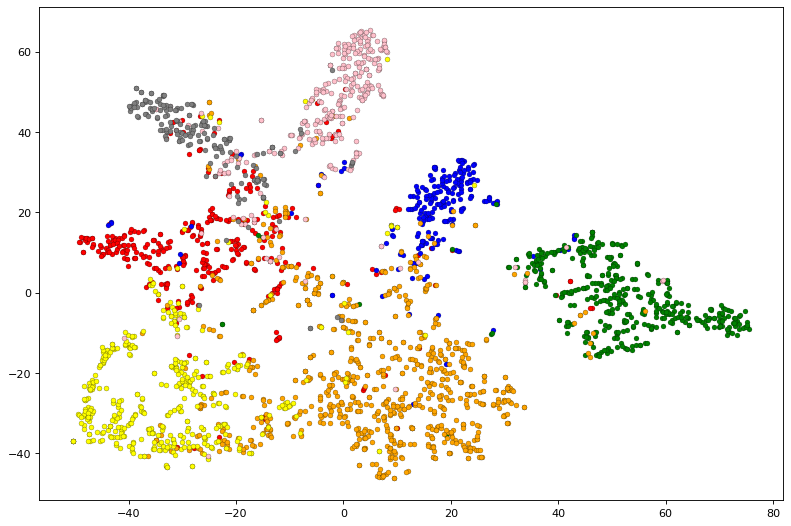

In [22]:
model_name=r'gat_000004.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name=DatasetType.CORA.name


visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)

Visualizing Attension

/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)



***** Model training metadata: *****
commit_hash: 39c8f0ee634477033e8b1a6e9a6da3c7ed71bbd1
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.827
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.4
*************************************

Highest degree nodes = [1986 1701  306 1358]
Max attention weight = 0.01768956147134304 and min = 0.007854463532567024


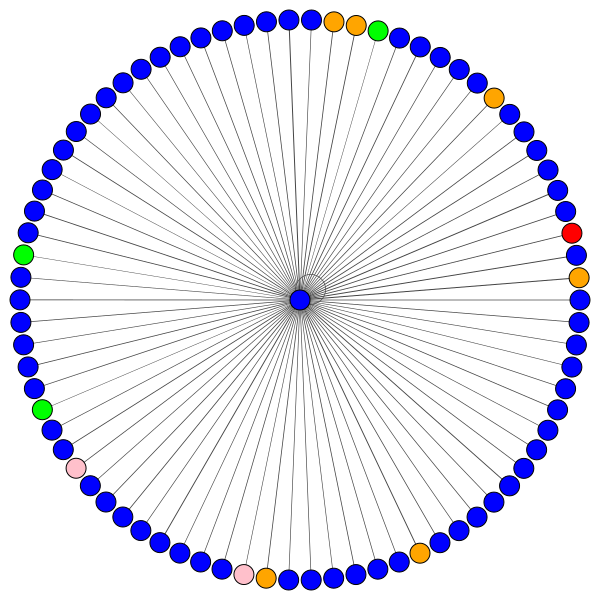

In [23]:
# Fetch the data we'll need to create visualizations
all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)

# The number of nodes for which we want to visualize their attention over neighboring nodes
num_nodes_of_interest = 4  # 4 is an arbitrary number you can play with these numbers
head_to_visualize = 0  # plot attention from this multi-head attention's head (last layer only has a single head)
gat_layer_id = 1  # plot attention from this GAT layer (since our GAT only has 2 layers this is the last layer)

# Build up the complete graph
# node_features shape = (N, FIN), where N is the number of nodes and FIN number of input features
total_num_of_nodes = len(node_features)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes)  # igraph creates nodes with ids [0, total_num_of_nodes - 1]
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  # igraph requires this format
complete_graph.add_edges(edge_index_tuples)

# Pick the target nodes to plot (nodes with highest degree + random nodes)
# Note: there could be an overlap between random nodes and nodes with highest degree - but highly unlikely
highest_degree_node_ids = np.argpartition(complete_graph.degree(), -num_nodes_of_interest)[-num_nodes_of_interest:]
random_node_ids = np.random.randint(low=0, high=total_num_of_nodes, size=num_nodes_of_interest)

print(f'Highest degree nodes = {highest_degree_node_ids}')
      
target_node_ids = edge_index[1]
source_nodes = edge_index[0]


target_node_id = 306  # 306 is the 2nd highest degree node


src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
size_of_neighborhood = len(source_node_ids)

# Step 2: Fetch their labels
labels = node_labels[source_node_ids].cpu().numpy()

all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()
# This part shows that for CORA what GAT learns is pretty much constant attention weights! Like in GCN!
print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights)  # rescale the biggest weight to 1 for nicer plotting

id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

# Prepare the visualization settings dictionary and plot
visual_style = {
    "edge_width": attention_weights,  # make edges as thick as the corresponding attention weight
    "layout": ig_graph.layout_reingold_tilford_circular()  # layout for tree-like graphs
}
# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in labels]
else:
    print('Add custom color scheme for your specific dataset. Using igraph default coloring.')

ig.plot(ig_graph, **visual_style)

Histogram Part 2


***** Model training metadata: *****
commit_hash: 39c8f0ee634477033e8b1a6e9a6da3c7ed71bbd1
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.827
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.4
*************************************



/state/partition1/job-46452332/ipykernel_589065/1424749847.py:32: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


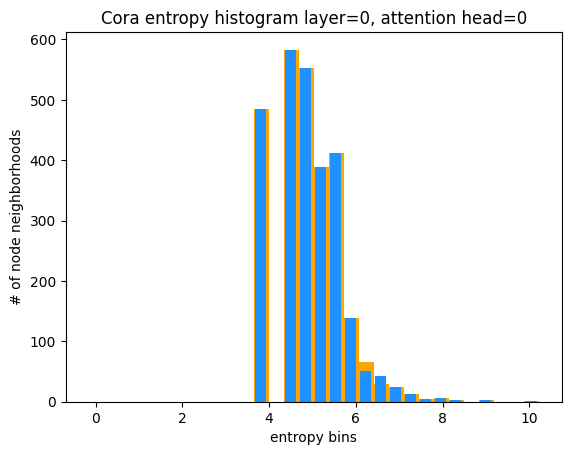

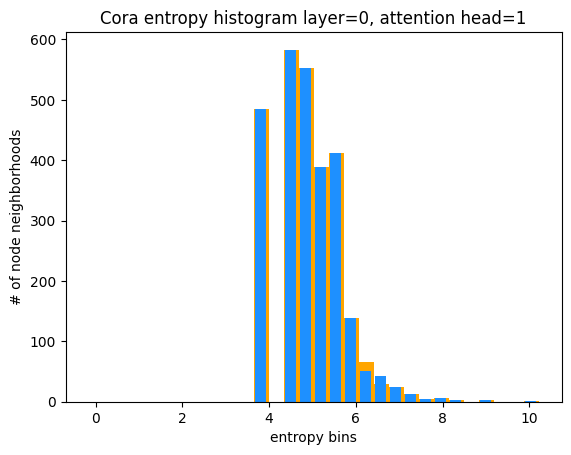

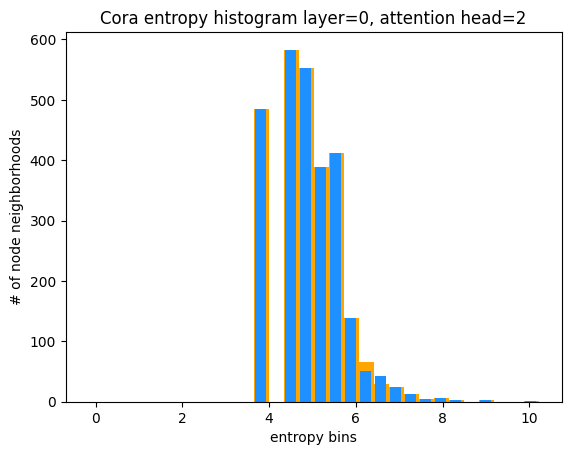

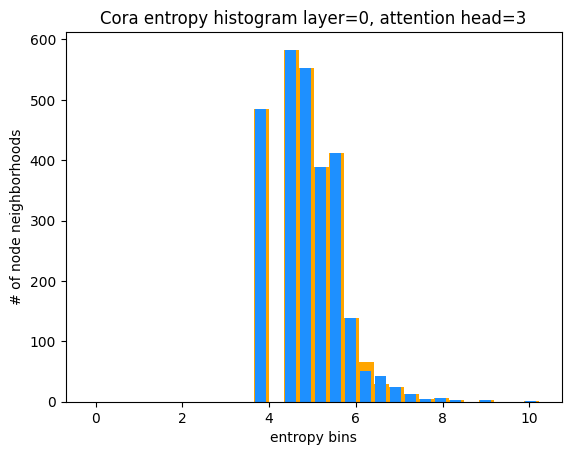

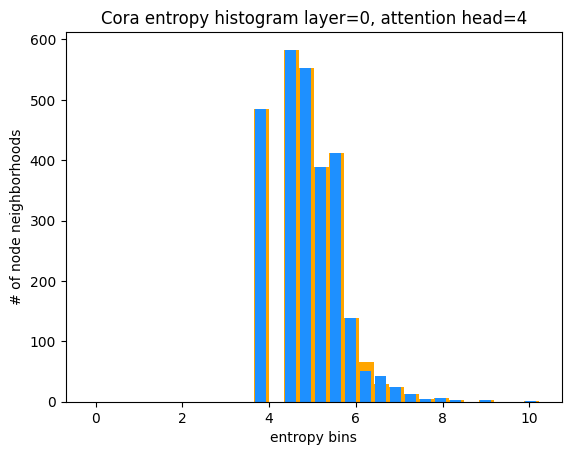

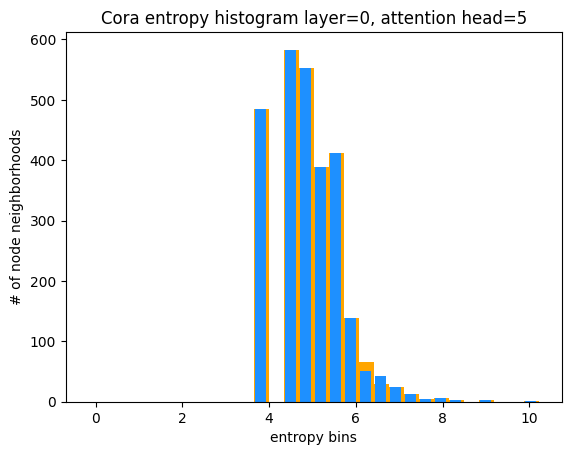

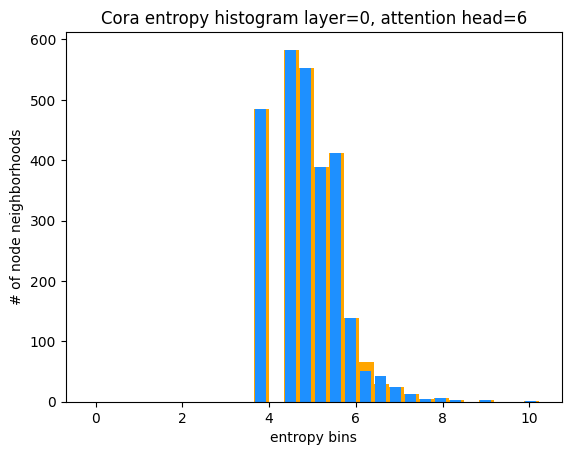

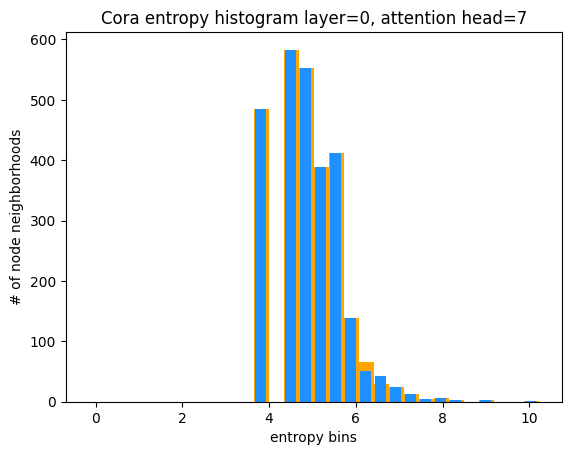

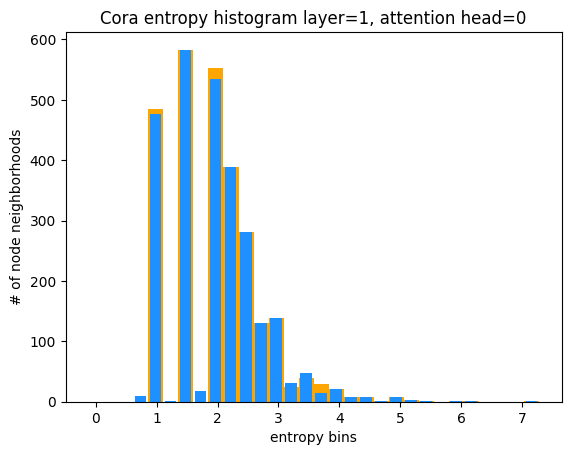

In [24]:
# pick between attention, t-SNE embeddings and entropy
visualize_gat_properties(model_name, dataset_name,visualization_type=VisualizationType.ENTROPY)